# Labeling Data with OpenAI's API

## Setting the enviroment

In [56]:
import pandas as pd
import re
import numpy as np
import openai
import os
import time
import json
from datetime import datetime
import Levenshtein

## Data Collection
The data use in this demonstration is comprised of bill descriptions from a car shop chain that wants to organize its bills by 9 main categories.

In [59]:
DF = pd.read_csv('https://drive.google.com/uc?id=1iSkvyHnEXf1OKNt6jbVY4rmSBRargo9g')
DF.drop(columns='index', inplace=True)
DF.head()

,description
0,2 EXHAUST PIPE
1,2 EXTENSION PIPES
2,2 rear struts
3,MASTER CYLINDER
4,oil change & filter


## Preliminary Data Cleaning

To feed our the DataFrame into OpenAI's API, we must first get rid of the clutter and the irrelevant entries. Such as the bill descrioptions with only numerical data, dates, undesirable symbols and purely numerical entries.

In [25]:
#We naw define the cleaning function
def preliminar_cleaning(DF: pd.DataFrame, column_name: str):
    DF[column_name] = DF[column_name].str.lower()
    DF[column_name] = DF[column_name].str.replace(' ,', ' ')
    DF[column_name] = DF[column_name].str.replace(',', ' ')
    DF[column_name] = DF[column_name].str.replace('.', ' ')
    DF[column_name] = DF[column_name].str.replace('w/', 'with ')
    DF[column_name] = DF[column_name].str.replace('-', ' ')
    DF[column_name] = DF[column_name].str.replace('`', ' ')
    DF[column_name] = DF[column_name].str.replace('#', ' ')
    DF[column_name] = DF[column_name].str.replace('|', ' ')
    DF[column_name] = DF[column_name].str.replace('*', ' ')
    DF[column_name] = DF[column_name].str.replace('...', ' ')
    DF[column_name] = DF[column_name].str.replace(r'\d{1,2,3,4}-\d{1,2}-\d{1,2,3,4}', ' ')
    DF[column_name] = DF[column_name].str.replace(r'\d{1,2,3,4}\/\d{1,2}\/\d{1,2,3,4}', ' ')
    DF[column_name] = DF[column_name].str.replace(r'$ \d{1,2,3,4,5}', ' ')
    DF[column_name] = DF[column_name].str.replace(r'$\d{1,2,3,4,5}', ' ')
    DF[column_name] = DF[column_name].str.replace('r/l', 'right left')
    DF[column_name] = DF[column_name].str.replace('r & l', 'right left')
    DF[column_name] = DF[column_name].str.replace(r'\s+', ' ')
    DF[column_name] = DF[column_name].replace('', np.nan).replace(r'^\s*$', np.nan, regex=True)
    DF[column_name] = DF[column_name].str.strip()
    #DROP THE STRINGS WITH LENGHT 2 OR LESS
    mask = DF[column_name].str.len() < 3
    DF = DF[~mask]
    #DROP NAN
    DF.dropna(subset=[column_name], inplace= True)
    #DROP ONLY NUMERICAL VALUES
    mask = pd.to_numeric(DF[column_name], errors='coerce').notnull()
    DF = DF[~mask]

In [60]:
# WE APPLY THE FUNCTION ON OUR DATAFRAME
preliminar_cleaning(DF=DF, column_name='description')
DF.head()
DF_clean = DF.drop_duplicates(inplace=False, subset='description').dropna(subset='description', inplace=False)

In [ ]:
DF_clean.reset_index(inplace=True)
DF_clean.drop(columns='index', inplace=True)

## Data Labeling
For the actual data labeling process, we first will define a log. This log will keep track of our exchanges with OpenAI's API. Mainly to monitor the amount of tokens used and the time taken to label the bill descriptions.

In [28]:
def print_billing(prompt="", response={}, final=False ):

    file_name ="token_data/tokens_data.json"
    if final:
        file_1 = open(file_name,"a")
        file_1.write("\n]")
        file_1.close()
        return None
    
    di = {"date": str(datetime.now()),
            "model" : response["model"],
            "prompt": prompt,
            "response": response.choices[0].message.content,
            "completion_tokens": response["usage"]["completion_tokens"],
            "prompt_tokens": response["usage"]["prompt_tokens"],
        }
    
    if not os.path.isfile(file_name):
        file_1 = open(file_name,"a")
        file_1.write("[\n")
        file_1.write("{}".format(json.dumps(di)))
        file_1.close()
        return None
    
    file_1 = open(file_name,"a")
    file_1.write(",\n{}".format(json.dumps(di)))
    file_1.close()

Now, we can define the function that will connect with OpenAI's API. To do this, we will need to provide a private key. We will use the model "gpt-3.5-turbo" wich is the recommended to this kind of task.

In [29]:
#we define the labeling functions: prompt an layout
openai.api_key = os.getenv("OPENAI_API_KEY") #we use our apen ai key
def gpt_category_bot(bill_description: str):

    prompt = f"""You are a car expert. Label the next data:
{bill_description}
In one or multiple of the next categories:
 1. Shocks, Control Arms, Tires, Alignment
 2. Oil Change, Ignition, Fuel System
 3. Manufacturer Service Intervals
 4. Dashboard, Door Locks, Windows
 5. Check Engine Light, Inspections
 6. Alternator, Battery, Starter, Switches
 7. AC System, Blower Motor
 8. ABS Control Module, Brake Lines, Brake Pads
 9. None


return a two column table with each data entry and the category numbers (not the name of the category), use "|" to separate the columns
"""
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages = [{'role': 'user', 'content': prompt}],
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0)
    print_billing(prompt=prompt, response=response)
    
    return response.choices[0].message.content

With the labeling function properly defined. We can feed our data set to it. We will pass batches of 100 descriptions. To accomplish this we have to define a loop wich will iterate over the data in the amounts of rows we specified.

In [38]:
# Then, we create a loop wich will run over the whole dataframe
number_of_iterations = DF_clean.shape[0]
max_number_of_descriptions = 100
raw_labels = []

index = 0
while index < number_of_iterations:
    descriptions = DF_clean['description'][index] + "\n"
    #GET THE NUMBER OF ROWS TO CATEGORIZE /batch size
    for i in range(1, max_number_of_descriptions, 1):
        if index + i > number_of_iterations - 1:
            i += -1
            break
        
        descriptions += str(DF_clean['description'][index + i]) + "\n"
        
        
    try:
        response = gpt_category_bot(bill_description=descriptions)
        

    except openai.error.Timeout:
        print('TIMEOUT ERROR')
        time.sleep(10)
        continue
    
    except openai.error.APIError:
        print('API ERROR')
        time.sleep(10)
        continue
    
    except openai.error.RateLimitError:
        print('RATE TIME LIMIT EXCEDED')
        time.sleep(60)
        continue

    #GET THE RESPONSE INTO OUR LIST
    for ind_response in response.split('\n'):
        raw_labels.append(ind_response)

    index = index + i + 1
    print(index)


100
200
300
400
500
561


## Results Cleaning
Once the recently generated by chat GPT, we have to make sure the labels are in the correct format.

In [45]:
# NOW, WE HAVE TO CLEAN EACH ROW
def label_cleaning(label_list: list):
    result = []
    for item in label_list:
        if len(item) == 0: continue
        if item[0] == '|': item = item[1:]
        if item[-1] == '|': item = item[:-1]
        if len(item.split('|')) < 2: continue
        if len(item.split('|')) >= 2:
            labels = ','.join(item.split('|')[1:])
            labels = re.sub(r',\s+', ',', labels)
            labels = re.sub(r'\s+,', ',', labels)
            labels = labels.strip()
            if labels[0] == ',': labels = labels[1:]
            item = item.split('|')[0] + '|' + labels
        description = item.split('|')[0]
        description = re.sub(r'\s+', ' ', description)
        description = description.strip()
        item = description + '|' + labels
        result.append(item)
    
    return result

clean_labels = label_cleaning(raw_labels)

for i in clean_labels:
    print(i)

print(len(clean_labels))

2 exhaust pipe|9
2 extension pipes|9
2 rear struts|1
master cylinder|8
oil change & filter|2
front alignment|1
replaced flex pipe|9
rear wheel cylinder|8
cat converters|2
front brakes|8
serp belt 4060473|9
brake fluid|8
front brake pads|8
used transmission|9
replace spark plug|2
extension pipe|9
r&r flex pipe|9
3 extension pipes|9
labor on oil|2
labor on pipe|9
evap canister|5
on fan clutch|6
fuel filter|2
exhaust pipe|9
wheel alignment|1
one extension pipe|9
connecting pipe|9
1 universal muffler|9
thermostat housing|6
synthetic oil|2
exhaust flex pipe|9
on dpfe sensor|5
outer tie rods|1
r&r muffler|9
oil & filter|2
1 exhaust pipe|9
wiper blades|4
replace 1 tire|1
extension pipes (2)|9
universal muffler|9
muffler labor only|9
oil change|2
catalytic converter|2
a/c recharge|7
a/c service|7
front brake rotors|8
r&r flex pipes|9
sway bar repair kit|1
(univ) flex pipe|9
oil and filter|2
r&r water pump|6
sleeve pipe|9
used catalytic|2
full brake lines|8
replace ext pipe|9
r & r muffler (one

Then, we pair each label to the correspondant entry. To take into account the mistakes made by chat GPT and the automatical corrections it makes to entries with orthografic mistakes we have to use the Levenhstein function. This will let us pair the changed chat GPT responses with the original entries. For our task we have set the maximun distance to 2.

In [97]:
#NOW, WE CAN PAIR EACH LABELED DESCRIPTION WITH ITS ORIGINAL DESCRIPTION
DF['label'] = np.nan

for i in range(2, -1, -1):
    for index, row in DF.iterrows():
        for chat_gpt_output in clean_labels:
            if Levenshtein.distance(row['description'], chat_gpt_output.split('|')[0]) <= i:
                DF['label'][index] = chat_gpt_output.split('|')[1]

C:\Users\leomj\AppData\Local\Temp\ipykernel_5260\1193826332.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['label'][index] = chat_gpt_output.split('|')[1]


"for row in clean_labels:\n    indices = DF[DF['description'] == row.split('|')[0]].index\n    DF['label'][indices] = row.split('|')[1]"

After pairing all of the labels we can count the number of empty labels with the line of code:

In [98]:
DF['label'].isna().sum()

12

Wich is a 2.14% of the total labels.

In [86]:
DF.head()

,description,label
0,2 exhaust pipe,9
1,2 extension pipes,9
2,2 rear struts,1
3,master cylinder,8
4,oil change & filter,2


Finally, we can extract data from the lables. For example we can begin by ploting the distribution of the labels assigned by OpenAI's API.

<Axes: xlabel='label'>

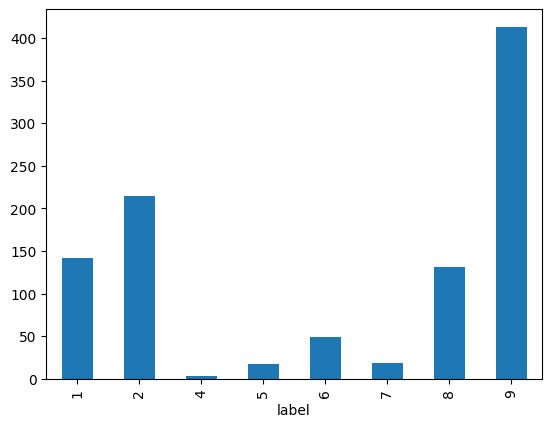

In [99]:
from matplotlib import pyplot as plt
DF_hist = DF.groupby(by='label')['label'].count()
DF_hist.head(10)
DF_hist.plot(kind='bar', x='label')

### Author
Leonardo Mier \
leo97mier@gmail.com